# OpenFoodFacts - Analysis of Sugar Nutrient Levels

__Goal__: Investigate the sugar nutrient levels (i.e. low, moderate, high) in Open Food Facts products.

<div class="alert alert-block alert-info">
  <b>This notebook focuses on the top 1,000 products in Open Food Facts which have complete nutrition data.</b>
</div>

__To be analyzed:__
  - the distribution of sugar amounts per nutrient levels
  - potential overlap of nutrient levels
  - alignment of nutrient levels with FSA-defined nutrient levels

The Food Standards Agency (FSA) in UK defined nutrient levels for fat, saturated fat, sugar and salt in 2007 and revised it in 2016.
- https://www.nhs.uk/live-well/eat-well/food-guidelines-and-food-labels/how-to-read-food-labels/
- https://www.food.gov.uk/sites/default/files/media/document/fop-guidance_0.pdf

__Summary (TL;TR)__
  - General
    - The defintion of nutrient levels for beverages and food is different
    - The EU only defines a reference value for "low" for allowed marketing claims
  - Analysis Results
    - There is an overlap of nutrient levels in OFF products, which should not be the case
    - The nutrient levels of OFF products are not in line with the revised FSA definition

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen, urlretrieve
from urllib.parse import urlencode
from pathlib import Path
import json
import math
from typing import Union

## Download Data from OpenFoodFacts API

___Only fetch the top 1,000 products with complete nutrition information!___

see also https://openfoodfacts.github.io/openfoodfacts-server/api/ref-v2/#cmp--schemas-product-nutrition

In [2]:
scope = "world"
API_URL = f"https://{scope}.openfoodfacts.org/api/v2/search?"
DATA_FILE = f"../data/off_{scope}_nutrients_top1000.json"

PARAMS = {
    "page_size": 1000,
    "states_tags": "nutrition-facts-completed",
    "sort_by": "unique_scans_n",
    "fields": "code,product_name,brands,nutrient_levels,sugars_100g,sugars_serving,serving_size,nutriscore_data"
}

# skip download if data has been downloaded before
if not Path(DATA_FILE).exists():
    urlretrieve(API_URL + urlencode(PARAMS), DATA_FILE)

In [3]:
# load json file
with open(DATA_FILE) as f:
    data = json.load(f)

# create data frame from product information
prod_df = (pd.DataFrame(data['products'])
            .drop(['brands'], axis=1)
            .set_index('code')
          )

def is_flag(value: Union[str, int]):
    try:
        return 1 == (int(value) if isinstance(value, str) and value != "" else value)
    except ValueError as e:
        print(f"cannot parse {value}", e)
        return False

# extract product type flags and nutrient levels
flags = ["is_beverage", "is_cheese", "is_fat", "is_water"]
levels = ["fat", "saturated-fat", "sugars", "salt"]

for flag in flags:
    prod_df[flag] = prod_df.nutriscore_data.map(lambda nutri: is_flag(nutri[flag]) if (isinstance(nutri, dict) and flag in nutri) else False)

for level in levels:
    prod_df[level] = prod_df.nutrient_levels.map(lambda nutri: nutri[level] if (isinstance(nutri, dict) and level in nutri) else None)

display(prod_df)

,nutrient_levels,nutriscore_data,product_name,serving_size,sugars_100g,sugars_serving,is_beverage,is_cheese,is_fat,is_water,fat,saturated-fat,sugars,salt
code,,,,,,,,,,,,,,
3274080005003,"{'fat': 'low', 'salt': 'low', 'saturated-fat':...","{'energy': 0, 'energy_points': 0, 'energy_valu...",Eau de source,1 L,0.0,0.00,True,False,False,True,low,low,low,low
7622210449283,"{'fat': 'moderate', 'salt': 'moderate', 'satur...","{'energy': 1962, 'energy_points': 5, 'energy_v...",Prince Chocolat biscuits au blé complet,20g,32.0,6.40,False,False,False,False,moderate,high,high,moderate
3017620425035,"{'fat': 'high', 'salt': 'low', 'saturated-fat'...","{'energy': 2252, 'energy_points': 6, 'energy_v...",Nutella,15 g,56.3,8.44,False,False,True,False,high,high,high,low
3175680011480,"{'fat': 'moderate', 'salt': 'moderate', 'satur...","{'energy': 1961, 'energy_points': 5, 'energy_v...",Biscuit Sésame,11.5g,17.0,1.96,False,False,False,False,moderate,moderate,high,moderate
5449000214911,"{'fat': 'low', 'salt': 'low', 'saturated-fat':...","{'energy': 180, 'energy_points': 6, 'energy_va...",Coca-cola,330ml,10.6,35.00,True,False,False,False,low,low,high,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5410081201039,"{'fat': 'high', 'salt': 'low', 'saturated-fat'...","{'energy': 2209, 'energy_points': 6, 'energy_v...",L'Original noir,25 g,53.0,13.20,False,False,False,False,high,high,high,low
5411188115496,"{'fat': 'moderate', 'salt': 'low', 'saturated-...","{'energy': 138, 'energy_points': 0, 'energy_va...",Sojadrink ohne Zucker,100 ml,0.0,0.00,False,False,False,False,moderate,low,low,low
5449000214843,"{'fat': 'low', 'salt': 'low', 'saturated-fat':...","{'energy': 182, 'energy_points': 7, 'energy_va...",Coca-Cola Cherry,330ml,10.7,35.30,True,False,False,False,low,low,high,low


## Explorative Data Analysis

Sugar Levels:
- count number of products with low, moderate, high sugar level
- distinguish beverages and general food products

In [4]:
# remove products with missing sugar value
prod_df = prod_df[lambda df: df.sugars_100g.map(pd.notna)]

In [5]:
prod_df.sugars.value_counts(dropna=False)

sugars
low         422
high        370
moderate    158
None         19
Name: count, dtype: int64

In [6]:
prod_df.is_beverage.value_counts(dropna=False)

is_beverage
False    852
True     117
Name: count, dtype: int64

In [7]:
print("Products sorted by amount of sugar (per 100g)")
display(prod_df.sort_values("sugars_100g").drop(columns=["nutrient_levels", "nutriscore_data", "fat", "saturated-fat", "salt"]))

Products sorted by amount of sugar (per 100g)


,product_name,serving_size,sugars_100g,sugars_serving,is_beverage,is_cheese,is_fat,is_water,sugars
code,,,,,,,,,
3274080005003,Eau de source,1 L,0.0,0.0,True,False,False,True,low
3154230810131,Jambon le bon Paris,35g,0.0,0.0,False,False,False,False,low
3019081238643,Sardines Huile d'Olive Vierge Extra,95 g,0.0,0.0,False,False,False,False,low
3175681116832,Biscuit Coco,11g,0.0,0.0,False,False,False,False,low
5000373704289,Dairy Free Spread,NaN,0.0,NaN,False,False,True,False,low
...,...,...,...,...,...,...,...,...,...
3165432640006,Sucre de glace,NaN,98.0,NaN,False,False,False,False,high
20711115,cassonade,NaN,98.9,NaN,False,False,False,False,high
3220035210008,Sucre Cassonade,NaN,99.0,NaN,False,False,False,False,high


# Plot Sugar Levels

In [8]:
beverages_df = prod_df[prod_df.is_beverage]
non_beverages_df = prod_df[~prod_df.is_beverage]

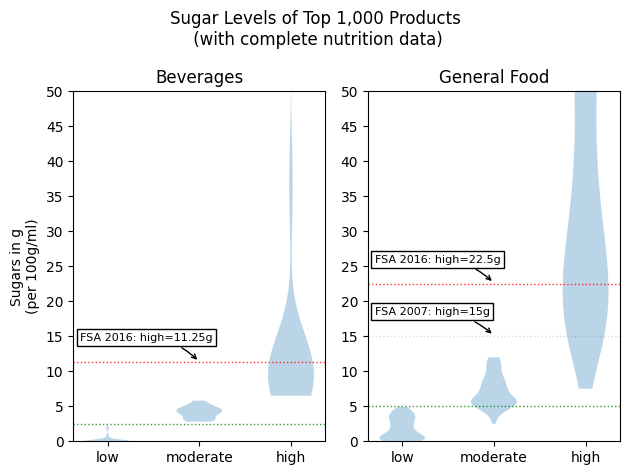

In [9]:
lvls = ["low", "moderate", "high"]

beverage_data = list(map(lambda df: df.sugars_100g.values, [beverages_df[lambda x: x.sugars == lvl]for lvl in lvls]))
non_beverage_data = list(map(lambda df: df.sugars_100g.values, [non_beverages_df[lambda x: x.sugars == lvl]for lvl in lvls]))

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

ax1.violinplot(dataset = beverage_data, showextrema=False);
ax1.axhline(y=2.5, color='g', linestyle=':', linewidth=1, alpha=0.8)
#ax1.axhline(y=7.5, color='grey', linestyle=':', linewidth=1, alpha=0.3)
ax1.axhline(y=11.25, color='r', linestyle=':', linewidth=1, alpha=0.8)
ax1.set_xticks([1,2,3], labels=lvls);
ax1.set_yticks(range(0, 100, 5));
ax1.set_ylim([0,50])
ax1.set_title("Beverages")
ax1.set_ylabel("Sugars in g\n(per 100g/ml)")

ann = ax1.annotate("FSA 2016: high=11.25g",
                  xytext=(0.7, 14.8), textcoords='data',
                  xy=(2, 11.35), xycoords='data',
                  size=8, va="center", ha="left",
                  bbox=dict(boxstyle="square", fc="w", pad=0.3),
                  arrowprops=dict(arrowstyle="->",
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="w"))

ax2.violinplot(dataset = non_beverage_data, showextrema=False);
ax2.axhline(y=5, color='g', linestyle=':', linewidth=1, alpha=0.8)
ax2.axhline(y=15.0, color='grey', linestyle=':', linewidth=1, alpha=0.3)
ax2.axhline(y=22.5, color='r', linestyle=':', linewidth=1, alpha=0.8)
ax2.set_xticks([1,2,3], labels=lvls);
ax2.yaxis.set_tick_params(which='both', labelbottom=True)
#ax2.set_yticks(range(0, 100, 5));
ax2.set_title("General Food");

ann = ax2.annotate("FSA 2016: high=22.5g",
                  xytext=(0.7, 26), textcoords='data',
                  xy=(2, 22.6), xycoords='data',
                  size=8, va="center", ha="left",
                  bbox=dict(boxstyle="square", fc="w", pad=0.3),
                  arrowprops=dict(arrowstyle="->",
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="w"))
ann = ax2.annotate("FSA 2007: high=15g",
                  xytext=(0.7, 18.5), textcoords='data',
                  xy=(2, 15.1), xycoords='data',
                  size=8, va="center", ha="left",
                  bbox=dict(boxstyle="square", fc="w", pad=0.3),
                  arrowprops=dict(arrowstyle="->",
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="w"))

fig.suptitle("Sugar Levels of Top 1,000 Products\n (with complete nutrition data)");
fig.tight_layout()

plt.savefig("sugar-levels.png")

In [10]:
# min/max sugar grams per level in beverages

print([min(x) for x in beverage_data])
print([max(x) for x in beverage_data])

[0.0, 2.8, 6.5]
[2.2, 5.8, 73.0]


In [11]:
# min/max sugar grams per level in general food

print([min(x) for x in non_beverage_data])
print([max(x) for x in non_beverage_data])

[0.0, 2.5, 7.5]
[4.9, 12.0, 100.0]


### Inspect products with wrong sugar level

- high sugar level
- sorted by sugar grams

In [12]:
prod_df[lambda x: ~x.is_beverage & (x.sugars == "high")].sort_values("sugars_100g").head(20).drop(columns=["nutrient_levels", "nutriscore_data", "fat", "saturated-fat", "salt"])

,product_name,serving_size,sugars_100g,sugars_serving,is_beverage,is_cheese,is_fat,is_water,sugars
code,,,,,,,,,
20920210,Chicorée Café,2g,7.5,0.15,False,False,False,False,high
3664346306027,chocolat en poudre,20g,8.1,1.62,False,False,False,False,high
3664346315371,Grand Arôme moins de sucre,15g,8.4,1.26,False,False,False,False,high
3664346306003,Grand Arôme 32% de Cacao,15g + 200ml de lait,9.5,19.00,False,False,False,False,high
3033491351082,Activia bifidus saveur vanille sans arome arti...,125 g (Pot),12.6,15.80,False,False,False,False,high
3033491350795,Activia bifidus saveur citron sans arome artif...,125 g (Pot),12.6,15.80,False,False,False,False,high
3661344688339,Les 2 Vaches Vanille Bio de Madagascar 4 x 115 g,1 pot 115 g,12.8,14.70,False,False,False,False,high
20995553,Dark Chocolate - 85% Cocoa,12.5 g,12.9,1.61,False,False,False,False,high
7622400013935,Chocolat extra noir de dégustation 86% noir in...,20 g,13.0,2.60,False,False,False,False,high
